<a href="https://colab.research.google.com/github/alexttrt/Team5_adopt_linebot_project/blob/main/RestNet50_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: CNN

Dataset: custom dataset

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os # path
from glob import glob # search file paths
from tqdm.auto import tqdm # (optional) progress bar
from sklearn.model_selection import train_test_split
import shutil

# PyTorch
import torch
from torch import nn
import torchvision
from torchsummary import summary # model summary

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [ ]:
!pip install --upgrade gdown
!gdown --id 1XmMksQVuqRtemSQxF7jxDtUFNEm0rJj6 --output cat_train.zip
!unzip cat_train.zip

### Data

#### Check your data first

In [ ]:
# import zipfile
# file_cat = "cat_train.zip"
# a = zipfile.ZipFile(file_cat)
# a.extractall()
# a.close()

In [ ]:
IMG_SIZE = 256
NUM_CLASS = 7
all_calsses = ["black","white","orange","benz","sunflower","tiger","demo"]
class_map = {cls : i for i, cls in enumerate(all_calsses)}
class_map

{'black': 0,
 'white': 1,
 'orange': 2,
 'benz': 3,
 'sunflower': 4,
 'tiger': 5,
 'demo': 6}

In [ ]:
if not os.path.exists("cat_test"):
  for i in all_calsses:
    os.makedirs(f"cat_test/{i}")

In [ ]:
for i in range(60):
  for cat in all_calsses:
    img_path = sorted(glob(f"/content/cat_train/{cat}/*.jpg"))
    dest = f"/content/cat_test/{cat}"
    idx = np.random.randint(len(img_path))
    files = img_path[idx]
    shutil.move(files, dest)

In [ ]:
img_path[0:3]

['/content/cat_train/demo/istockphoto-1000237704-612x612.jpg',
 '/content/cat_train/demo/istockphoto-1000929058-612x612.jpg',
 '/content/cat_train/demo/istockphoto-1014573838-612x612.jpg']

In [ ]:
img_path_train = sorted(glob(f"/content/cat_train/*/*.jpg"))
img_path_test = sorted(glob(f"/content/cat_test/*/*.jpg"))
len(img_path_train), len(img_path_test)

(1608, 420)

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=["a","b","c","d","e"])
for i in range(len(img_path_train)):
  x = img_path_train[i].split("/")
  x = np.array(x)
  df.loc[i] = x


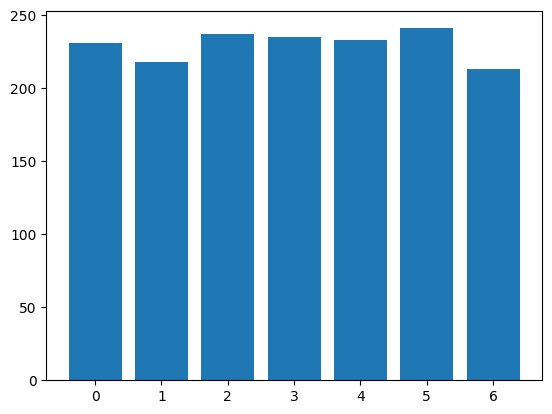

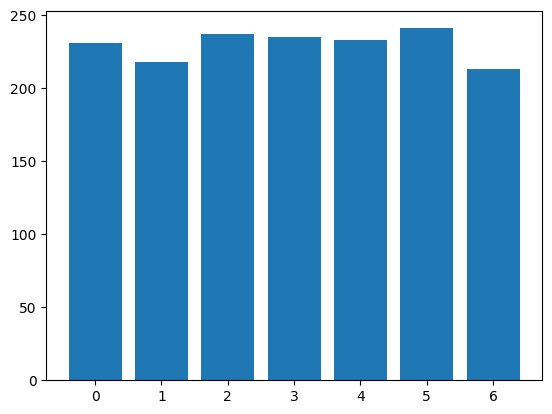

In [ ]:
# draw class distribution
def plot_distibution(path):
    values, counts = np.unique(df["d"], return_counts=True)
    plt.bar(range(len(values)), counts)
    plt.show()

plot_distibution(img_path_train)
plot_distibution(img_path_test)

/content/cat_train/demo/istockphoto-1296095964-612x612.jpg
(459, 612, 3)


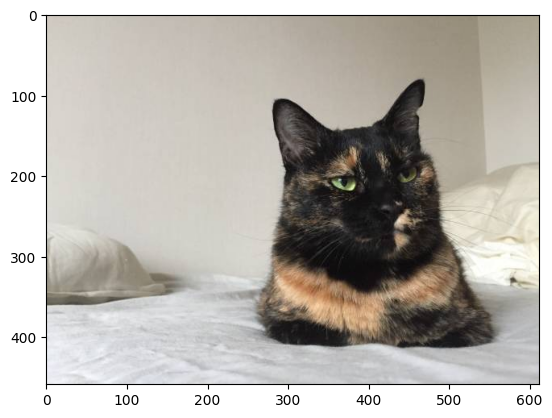

In [ ]:
# 秀出圖片
idx = np.random.randint(len(img_path_train))
path = img_path_train[idx]
print(path)
img = Image.open(path).convert("RGB")
img_np = np.array(img)
print(img_np.shape)
plt.imshow(img)

In [ ]:
# Extract img class
# os.sep: /
# 找到圖片類別
print(path)
print(path.split(os.sep))
cls = path.split(os.sep)[-2]
print(cls)

/content/cat_train/demo/istockphoto-1296095964-612x612.jpg
['', 'content', 'cat_train', 'demo', 'istockphoto-1296095964-612x612.jpg']
demo


In [ ]:
filename = path.split("/")[-1]
cls_cat = path.split("/")[-2]
cls = class_map[cls_cat]
print(filename)
print(cls_cat)
print(cls)

istockphoto-1296095964-612x612.jpg
demo
6


#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   \_\_getitem\_\_() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


Pixel value rescale

*   0~1
*   -1~+1 : (x/127.5) - 1
* (x-x.mean()) / x.std()

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, class_map):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map
    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        img = img / 255. # 0~255 -> 0.~1.

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        filename = path.split("/")[-1]
        cls = path.split("/")[-2]
        cls_idx = self.class_map[cls]

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [ ]:
# Build dataset
train_ds = Dataset(img_path_train, IMG_SIZE, class_map)
val_ds = Dataset(img_path_test, IMG_SIZE, class_map)

In [ ]:
# Number of samples
len(train_ds), len(val_ds)

(1608, 420)

torch.Size([3, 256, 256]) tensor(3) benz


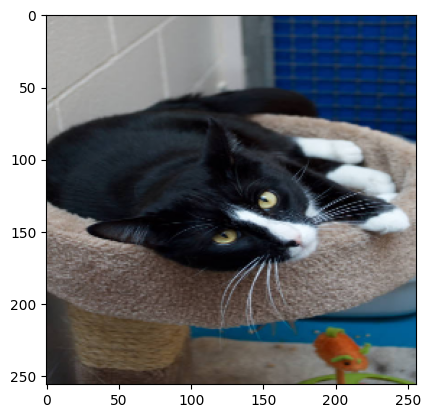

In [ ]:
img, label = train_ds[230]
print(img.shape, label, all_calsses[label])

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
plt.imshow(img)
plt.show()

In [ ]:
img, label

(tensor([[[0.6588, 0.6549, 0.6471],
          [0.6824, 0.6784, 0.6706],
          [0.6863, 0.6824, 0.6745],
          ...,
          [0.0078, 0.1765, 0.4471],
          [0.0078, 0.1725, 0.4627],
          [0.0118, 0.1765, 0.4588]],
 
         [[0.6627, 0.6588, 0.6510],
          [0.6863, 0.6824, 0.6745],
          [0.6863, 0.6824, 0.6745],
          ...,
          [0.0157, 0.1922, 0.4667],
          [0.0157, 0.1882, 0.4824],
          [0.0196, 0.1961, 0.4824]],
 
         [[0.6902, 0.6863, 0.6784],
          [0.6980, 0.6941, 0.6863],
          [0.6824, 0.6784, 0.6745],
          ...,
          [0.0039, 0.1922, 0.4784],
          [0.0078, 0.1922, 0.4980],
          [0.0157, 0.2000, 0.5020]],
 
         ...,
 
         [[0.2235, 0.2157, 0.2392],
          [0.1765, 0.1725, 0.1922],
          [0.1529, 0.1490, 0.1647],
          ...,
          [0.5020, 0.5451, 0.5294],
          [0.4745, 0.5137, 0.5176],
          [0.4471, 0.4863, 0.5020]],
 
         [[0.1922, 0.1922, 0.2000],
          [0

In [ ]:
# Build DataLoaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [ ]:
for (x, y) in val_loader:
    print(x.shape, y)

torch.Size([32, 3, 256, 256]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
torch.Size([32, 3, 256, 256]) tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 0, 0, 0, 0])
torch.Size([32, 3, 256, 256]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 256, 256]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        6, 6, 6, 6, 6, 6, 6, 6])
torch.Size([32, 3, 256, 256]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
torch.Size([32, 3, 256, 256]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32, 3, 256, 256]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])

### Model



*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **forward**(): connect **Input** to **Output**



*   Model architecture
    1.   Feature extractor (encoder)
    2.   Flatten
    3.   Classifier



In [ ]:
# model = torchvision.models.mobilenet_v3_small().to("cuda")

In [ ]:
# model.classifier = nn.Sequential(
#     nn.Linear(in_features=576, out_features=1024, bias=True),
#     nn.Hardswish(),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1024, out_features=7),
# ).to("cuda")

In [ ]:
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50
model = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
model.fc = nn.Linear(2048, 7).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

### Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=1e-2)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.6518, train_acc: 0.647     val_loss: 1.2388, val_acc: 0.929 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 0.7791, train_acc: 0.943     val_loss: 0.3596, val_acc: 0.979 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 0.2666, train_acc: 0.973     val_loss: 0.1596, val_acc: 0.993 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 0.1498, train_acc: 0.974     val_loss: 0.1010, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 0.0923, train_acc: 0.989     val_loss: 0.0677, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.0707, train_acc: 0.992     val_loss: 0.0612, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.0590, train_acc: 0.991     val_loss: 0.0504, val_acc: 0.993 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.0459, train_acc: 0.994     val_loss: 0.0480, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.0345, train_acc: 0.996     val_loss: 0.0362, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.0289, train_acc: 0.998     val_loss: 0.0327, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.0347, train_acc: 0.997     val_loss: 0.0342, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.0189, train_acc: 0.998     val_loss: 0.0303, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.0185, train_acc: 0.998     val_loss: 0.0276, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.0189, train_acc: 0.999     val_loss: 0.0256, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.0186, train_acc: 0.999     val_loss: 0.0284, val_acc: 0.993 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.0129, train_acc: 0.999     val_loss: 0.0241, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.0124, train_acc: 0.999     val_loss: 0.0239, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.0106, train_acc: 0.999     val_loss: 0.0209, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.0102, train_acc: 0.999     val_loss: 0.0217, val_acc: 0.993 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.0075, train_acc: 1.000     val_loss: 0.0192, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.0087, train_acc: 1.000     val_loss: 0.0207, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.0114, train_acc: 0.999     val_loss: 0.0204, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.0098, train_acc: 1.000     val_loss: 0.0191, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.0072, train_acc: 1.000     val_loss: 0.0182, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.0163, train_acc: 0.998     val_loss: 0.0459, val_acc: 0.983 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.0080, train_acc: 0.999     val_loss: 0.0164, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.0061, train_acc: 1.000     val_loss: 0.0189, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.0095, train_acc: 0.999     val_loss: 0.0166, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.0053, train_acc: 0.999     val_loss: 0.0159, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.0060, train_acc: 0.999     val_loss: 0.0203, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.0074, train_acc: 0.999     val_loss: 0.0182, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.0070, train_acc: 0.999     val_loss: 0.0174, val_acc: 0.998 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.0071, train_acc: 1.000     val_loss: 0.0220, val_acc: 0.995 


  0%|          | 0/51 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.0051, train_acc: 1.000     val_loss: 0.0184, val_acc: 0.998 
Earlystop!


#### Logs

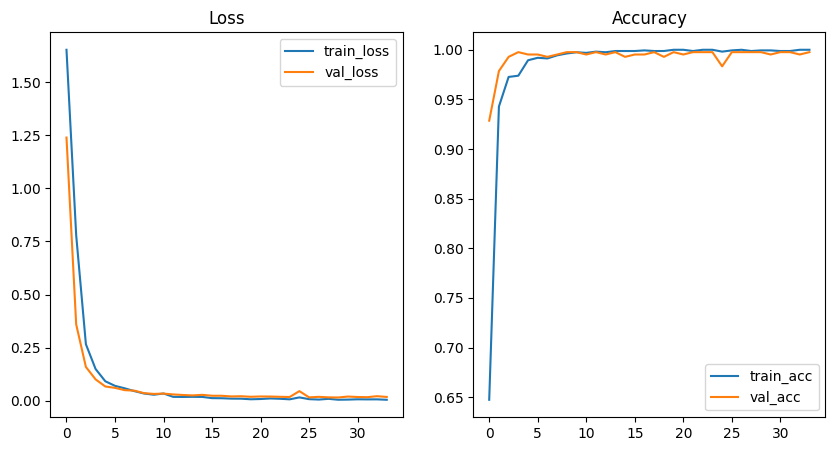

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save and load the model



1.   Save model weights only
2.   Save with model class architecture



1. Save model weights only

In [ ]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-4.6657e-03, -2.4709e-03,  3.7753e-02,  ...,  4.7476e-02,
                         -2.1371e-02,  8.2125e-03],
                        [-5.6899e-02,  4.4012e-02,  7.6933e-02,  ...,  8.7690e-02,
                          2.8577e-02, -5.9148e-02],
                        [ 6.8463e-02, -2.7079e-01,  4.0287e-01,  ..., -1.6510e-01,
                          2.1799e-01, -7.4020e-02],
                        ...,
                        [-1.0942e-01,  3.7842e-01, -4.5848e-01,  ...,  6.8137e-01,
                         -5.8012e-01,  2.2269e-01],
                        [ 2.4788e-02, -1.8052e-01,  6.4031e-01,  ...,  5.2321e-01,
                         -5.1849e-02, -7.0960e-02],
                        [ 4.4233e-02, -1.3442e-01,  1.3292e-02,  ..., -3.6269e-01,
                          1.8517e-01, -2.7063e-02]],
              
                       [[ 1.1352e-02,  5.6629e-03, -1.4695e-02,  ...,  8.6815e-02,
                         -6.6079

In [ ]:
# load model weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

2. Save with model class architecture

In [ ]:
torch.save(model, 'model.pth')

model = torch.load('model.pth')

#### Evaluation

In [ ]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [ ]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((420,), (420, 7), (420,))

In [ ]:
# calculate ACC
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.9976190476190476